# Weekly project
This weeks weekly project is a continuation of last weeks exercises.

You are to make a handwritten number classifier. Where we will be using the [mnist dataset](https://en.wikipedia.org/wiki/MNIST_database).

**Create a program that given an image from the mnist dataset.**
- You are free to use any algorithm you want to achieve this.
- It should be able to given a number classify what number it is.
- Accuracy should at least be 80%

If you decide to use a svm make sure you also use dimensionality reduction. SVM of the full mnist dataset will take around 4-8 hours depending on your pc.
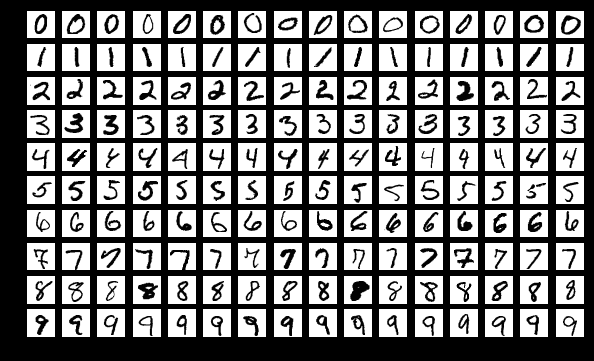

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
from sklearn.decomposition import PCA
from sklearn import datasets, svm, metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
mnist = fetch_openml('mnist_784', version=1)

images = mnist.data.to_numpy()
targets = mnist.target.to_numpy()

print(images.shape)
print(targets.shape)

(70000, 784)
(70000,)


C:\Users\henri\AppData\Local\Temp\ipykernel_22864\3784693246.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(nsamples/6.0), 6, index + 1)


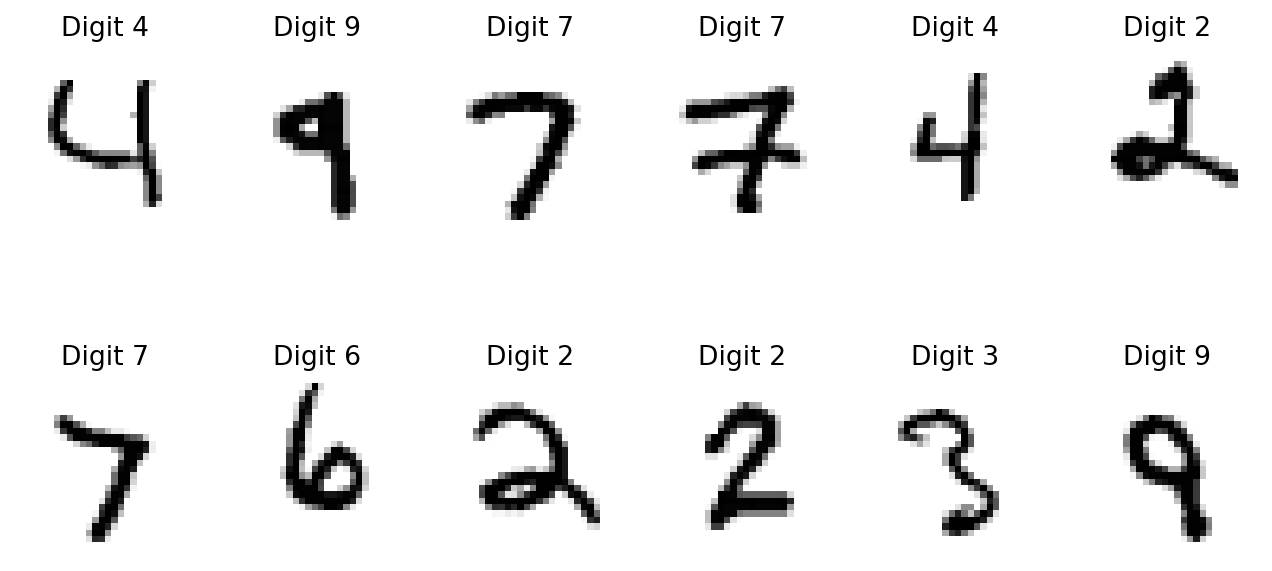

In [3]:
def show_some_digits(images, targets, sample_size=24, title_text='Digit {}' ):
    '''
    Visualize random digits in a grid plot
    images - array of flatten gidigs [:,784]
    targets - final labels
    '''
    
    nsamples=sample_size
    rand_idx = np.random.choice(images.shape[0], nsamples)
    images_and_labels = list(zip(images[rand_idx], targets[rand_idx]))


    img = plt.figure(1, figsize=(10, 5), dpi=160)
    for index, (image, label) in enumerate(images_and_labels):
        plt.subplot(np.ceil(nsamples/6.0), 6, index + 1)
        plt.axis('off')
        #each image is flat, we have to reshape to 2D array 28x28-784
        plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title_text.format(label))
    plt.show()

# draw 12 images along with their labels
show_some_digits(images, targets, 12)

#### PCA

In [13]:
pca = PCA(n_components = 81) # We only need two first principle components (2D space)
principalComponents = pca.fit_transform(images)

In [14]:
#print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

0.8920954328190718


#### Normalize data

In [15]:
X_scaled = MinMaxScaler().fit_transform(principalComponents)
X_scaled.shape

(70000, 81)

#### Test / traing split

Just doing one simple split, hopefully we have enough data to train our model. Also, each datapoint/image is independent so it doesnt matter where we take the data from.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, targets, test_size=0.15, shuffle=False, random_state=42)

#### Training 

In [17]:
########## PARAMETERS #########
C = 1.0                     ### 
gamma = "scale" #Default    ### 
degree = 3                  ###
######## PARAMETERS ###########
rbf_svc_classifier = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X_train, y_train)

In [18]:
rbf_svc_classifier.score(X_test, y_test)

0.9828571428571429

**As we see, the what we pass to the machine is not the same as what we would like when recognizing numbers**

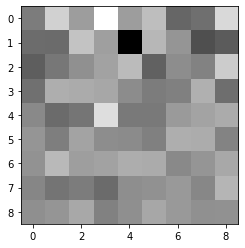

In [19]:
plt.imshow(principalComponents[0].reshape(9,9), cmap=plt.cm.gray_r, interpolation='nearest')

C:\Users\henri\AppData\Local\Temp\ipykernel_22864\3784693246.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(nsamples/6.0), 6, index + 1)


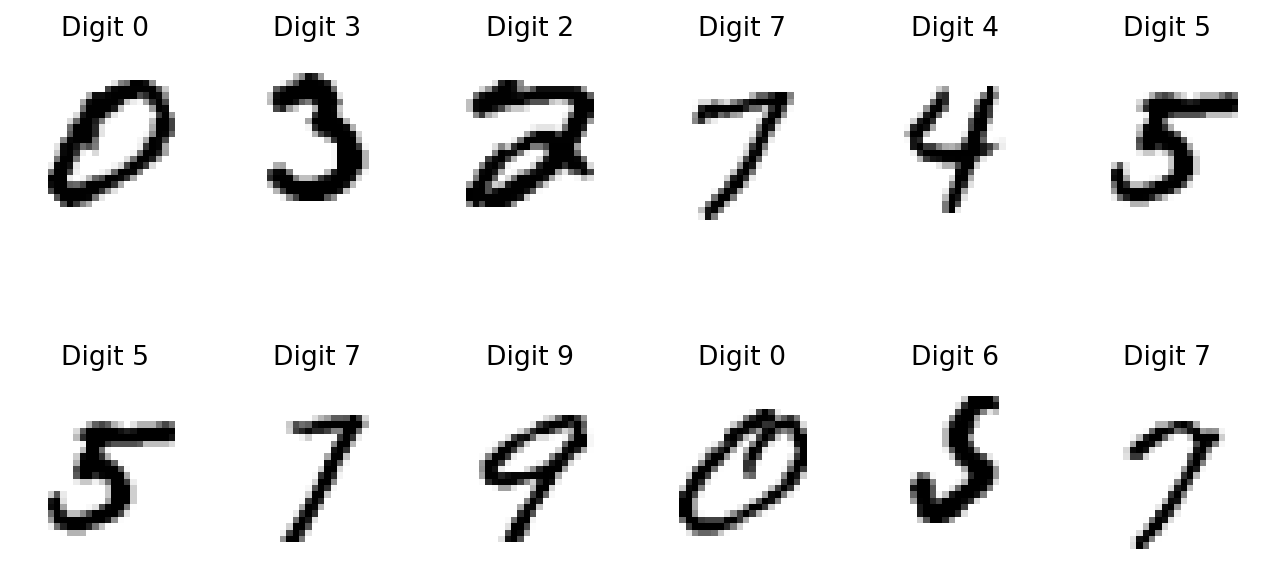

In [20]:
predictions = rbf_svc_classifier.predict(X_test[-50:])
show_some_digits(images[-50:], predictions, 12)

c = np.logspace(start = -15, stop = 1000, base = 1.02)
param_grid = {'C': c, "kernel" : ['linear', 'rbf', 'poly'], "gamma" : ["scale", "auto"]}

grid = sk.model_selection.GridSearchCV(sk.svm.SVC(), param_grid = param_grid, cv = 3, n_jobs = -1, scoring = 'accuracy')
grid.fit(principalComponents, target)

In [23]:
X_train.shape

(59500, 81)

**Challange:**
- Try to reach 98% accuracy.
- Try to classify faces with the labeled wild faces dataset [lwf](http://vis-www.cs.umass.edu/lfw/)
```{Python}
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
```

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [44]:
type(np.float32(targets)[0])
#targets

numpy.float32

In [47]:
np.float32(targets)

array([5., 0., 4., ..., 4., 5., 6.], dtype=float32)

In [54]:
# Model 1
model = tf.keras.Sequential()
model.add(layers.Dense(X_train.shape[-1], activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(10, activation=tf.nn.softmax)) 

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy']
              )

history = model.fit(x=X_scaled, y=np.float32(targets),
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

model.summary()


........................................................................................Epoch 00088: early stopping
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 81)                6642      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                5248      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 16,700
Trainable params: 16,700
Non-trainable params: 0
_________________________________________________________________


In [55]:
hist1 = pd.DataFrame(history.history)
hist1['epoch'] = history.epoch
hist1.tail(1)

,loss,accuracy,val_loss,val_accuracy,epoch
87,0.031471,0.989111,0.080249,0.981286,87


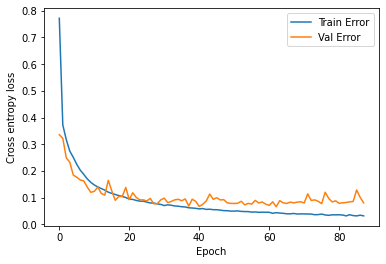

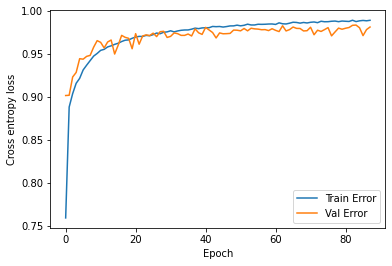

In [56]:
def plot_history_loss(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross entropy loss')
    #plt.yscale("log")
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

def plot_history_acc(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross entropy loss')
    #plt.yscale("log")
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend()


plot_history_loss(hist1)
plot_history_acc(hist1)

### NO PCA


In [58]:
# Model 1
model = tf.keras.Sequential()
model.add(layers.Dense(images.shape[-1], activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(10, activation=tf.nn.softmax)) 

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy']
              )

history = model.fit(x=images, y=np.float32(targets),
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

model.summary()


...........................................Epoch 00043: early stopping
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_37 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 10)                650       
Total params: 670,490
Trainable params: 670,490
Non-trainable params: 0
_________________________________________________________________


In [60]:
hist1 = pd.DataFrame(history.history)
hist1['epoch'] = history.epoch
hist1.tail(1)

,loss,accuracy,val_loss,val_accuracy,epoch
42,0.020264,0.99554,0.192522,0.981286,42


In [61]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_37 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 10)                650       
Total params: 670,490
Trainable params: 670,490
Non-trainable params: 0
_________________________________________________________________


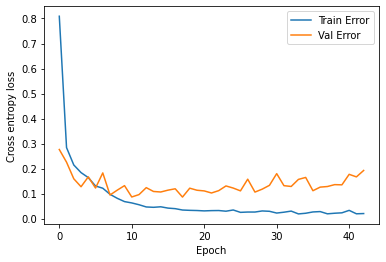

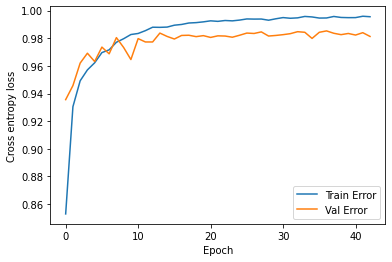

In [62]:
plot_history_loss(hist1)
plot_history_acc(hist1)